# Get Consensus from 3 LLMs on CWE Assignment

See https://cybersecai.github.io/Vulnrichment/Vulnrichment/ for context.

To optimize API and token usage and stay within limits, CVE-CWE pairs are processed in batches of batch_size CVE-CWE pairs.

This reduces the 
1. need to send the prompt for each CVE-CWE pair
2. number of calls to the API
   
The number needs to be small enough such that the Rationale from multiple CVE-CWE pairs fits within the output token limit for the LLM.


## LLM Info

### JSON Mode info 
1. https://ai.google.dev/gemini-api/docs/json-mode?lang=python 
2. https://platform.openai.com/docs/guides/json-mode
3. https://github.com/anthropics/anthropic-cookbook/blob/main/misc/how_to_enable_json_mode.ipynb "Claude doesn't have a formal "JSON Mode" with constrained sampling."

### Usage / Plan
1. OpenAI
   1. https://platform.openai.com/account/usage
   2. https://platform.openai.com/docs/guides/rate-limits/usage-tiers?context=tier-one
2. Gemini
   1. https://cloud.google.com/gemini/docs/quotas
3. Claude
   1. https://support.anthropic.com/en/articles/8324991-about-claude-pro-usage
   2. https://support.anthropic.com/en/articles/8325614-how-can-i-maximize-my-claude-pro-usage
   3. https://console.anthropic.com/settings/plans
   4. https://console.anthropic.com/settings/limits
   

### References
1. https://python.langchain.com/v0.1/docs/integrations/chat/openai/
2. https://claude3.pro/claude-3-5-sonnet-with-langchain/
3. https://python.langchain.com/v0.2/docs/integrations/chat/google_generative_ai/

In [1]:
#!pip install langchain_openai langchain_google_genai langchain_anthropic langchain

In [2]:
import pandas as pd
import json
import csv
import os
from datetime import datetime
from tqdm import tqdm
import traceback

from dotenv import dotenv_values
from dotenv import load_dotenv

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate

from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain.prompts import PromptTemplate
from langchain.prompts.chat import ChatPromptTemplate
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.schema import AIMessage
from concurrent.futures import ThreadPoolExecutor, as_completed

In [18]:

cwe_only_cisa_adp_input_file_path = 'data_out/extracted_cwe_info_cisa_adp_linux_only.csv'  # Entries with CWEs only
llm_consensus_file_path = './data_out/llm_consensus.csv'
llm_consensus_file_path_sorted = './data_out/llm_consensus_sorted.csv'

batch_size=10 # number of entries per batch i.e. number of CVE-CWE pairs in a prompt  
MAX_WORKERS=3 # threads


In [4]:

# load .env file to environment
load_dotenv()

config = dotenv_values(".env")

# Set up API keys (replace with your actual API keys)
os.environ["OPENAI_API_KEY"] = config['OPENAI_API_KEY']
os.environ["ANTHROPIC_API_KEY"] = config['ANTHROPIC_API_KEY']
os.environ["GOOGLE_API_KEY"] = config['GOOGLE_API_KEY']

#If using env vars
#GOOGLE_API_KEY=config['GOOGLE_API_KEY']
#OPENAI_API_KEY=config['OPENAI_API_KEY']
#ANTHROPIC_API_KEY=config['ANTHROPIC_API_KEY']


In [5]:
# Read the CSV file
try:
    df = pd.read_csv(cwe_only_cisa_adp_input_file_path, quoting=csv.QUOTE_ALL, escapechar='\\') # safe CSV

except FileNotFoundError:
    print("Error: CSV file not found.")
    exit(1)

In [6]:
#df=df[:20] # for test purposes take the first N rows only
df

,cve_id,Container,adp_providerMetadata_orgId,adp_providerMetadata_shortName,adp_providerMetadata_dateUpdated,CVE_Description,cna_providerMetadata_orgId,cna_providerMetadata_shortName,cna_providerMetadata_dateUpdated,CWE_ID,CWE_Description,description_length
0,CVE-2021-35559,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-25T16:05:50.566Z,Vulnerability in the Java SE Oracle GraalVM En...,NaN,NaN,NaN,CWE-400,CWE-400 Uncontrolled Resource Consumption,972
1,CVE-2021-26928,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-01T15:18:46.280Z,BIRD through does not provide functionality fo...,NaN,NaN,NaN,CWE-306,CWE-306 Missing Authentication for Critical Fu...,443
2,CVE-2021-26918,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-01T15:09:54.735Z,The ProBot bot through for Discord might allow...,NaN,NaN,NaN,CWE-434,CWE-434 Unrestricted Upload of File with Dange...,720
3,CVE-2021-34983,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-08T15:08:02.757Z,NETGEAR Multiple Routers httpd Missing Authent...,NaN,NaN,NaN,CWE-120,CWE-120 Buffer Copy without Checking Size of I...,621
4,CVE-2021-33990,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-07-12T15:32:38.330Z,Liferay Portal allows Command=FileUpload&Type=...,NaN,NaN,NaN,CWE-78,CWE-78 Improper Neutralization of Special Elem...,281
...,...,...,...,...,...,...,...,...,...,...,...,...
1879,CVE-2024-37762,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-07-08T15:13:35.601Z,MachForm up to version is affected by an authe...,NaN,NaN,NaN,CWE-434,CWE-434 Unrestricted Upload of File with Dange...,118
1880,CVE-2024-37634,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-13T20:21:11.912Z,TOTOLINK was discovered to contain a stack ove...,NaN,NaN,NaN,CWE-121,CWE-121 Stack-based Buffer Overflow,91
1881,CVE-2024-37535,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-10T12:55:15.708Z,GNOME VTE before allows an attacker to cause a...,NaN,NaN,NaN,CWE-400,CWE-400 Uncontrolled Resource Consumption,138
1882,CVE-2024-37019,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-04T14:49:54.923Z,Northern.tech Mender Enterprise before and bef...,NaN,NaN,NaN,CWE-287,CWE-287 Improper Authentication,73


In [7]:
# Set up LangChain for LLM interactions


llms = {
    "claude": ChatAnthropic(model="claude-3-sonnet-20240229", temperature=0,   timeout=None, max_retries=2),
    "gemini": ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0,  timeout=None, max_retries=2, generation_config={"response_mime_type": "application/json"}),
    #"gpt-4o": ChatOpenAI(model="gpt-4o", temperature=0, response_format={ "type": "json_object" })
}

# Define the prompt
# The Rationale string is last as it is most complex

# Update the prompt template
prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are a cybersecurity expert specializing in identifying Common Weakness Enumeration (CWE) IDs from CVE descriptions. Your goal is to analyze if you agree with the assigned CWE ID or not for multiple CVEs."),
    ("human", """
    Analyze the following CVEs and their assigned CWE IDs:
    
    {cve_entries}
    
    For each CVE, output a JSON object containing the following information:
    {{
        "Agree": string, // "Yes" or "No"
        "Confidence": float // a confidence score between 0 and 1
        "Rationale": string, // Only if you do not Agree, provide a rationale why not
    }}
    
    Respond with a JSON array containing an object for each CVE, in the same order as provided.
    """)
])

# Update the output parser
response_schemas = [
    ResponseSchema(name="Agree", description="Whether the model agrees with the assigned CWE ID"),
    ResponseSchema(name="Confidence", description="Confidence score between 0 and 1"),
    ResponseSchema(name="Rationale", description="Rationale for disagreement")
]
#output_parser = StructuredOutputParser.from_response_schemas(response_schemas)


I0000 00:00:1721569210.428364 1568087 config.cc:230] gRPC experiments enabled: call_status_override_on_cancellation, event_engine_dns, event_engine_listener, http2_stats_fix, monitoring_experiment, pick_first_new, trace_record_callops, work_serializer_clears_time_cache


In [8]:
def create_batch_prompt(batch, prompt_template):
    cve_entries = []
    for _, row in batch.iterrows():
        cve_entry = f"""
        CVE ID: {row['cve_id']}
        CVE Description: {row['CVE_Description']}
        Assigned CWE ID: {row['CWE_ID']}
        """
        cve_entries.append(cve_entry)
    
    batch_prompt = prompt_template.format(cve_entries="\n\n".join(cve_entries))
    return batch_prompt

def parse_response(response_content):
    try:
        parsed_responses = json.loads(response_content)
    except json.JSONDecodeError:
        start = response_content.find('[')
        end = response_content.rfind(']') + 1
        if start != -1 and end != -1:
            json_str = response_content[start:end]
            parsed_responses = json.loads(json_str)
        else:
            raise ValueError("Unable to parse response content")
    
    if not isinstance(parsed_responses, list):
        parsed_responses = [parsed_responses]
    
    return parsed_responses

def process_cve_batch(batch, llms, prompt_template, response_dir):
    batch_prompt = create_batch_prompt(batch, prompt_template)
    results = {}
    
    for model_name, llm in llms.items():
        try:
            # Save response to file
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

            response = llm.invoke(batch_prompt)
            parsed_responses = parse_response(response.content)

            filename = f"{model_name}_response_{timestamp}.json"
            filepath = os.path.join(response_dir, filename)
            with open(filepath, 'w') as f:
                json.dump({
                    'model': model_name,
                    'prompt': batch_prompt,
                    'response': response.content,
                    'parsed_responses': parsed_responses
                }, f, indent=2)
            
            for i, (_, row) in enumerate(batch.iterrows()):
                cve_id = row['cve_id']
                if cve_id not in results:
                    results[cve_id] = {
                        'CVE ID': cve_id,
                        'CVE Description': row['CVE_Description'],
                        'Assigned CWE ID': row['CWE_ID']
                    }
                
                if i < len(parsed_responses):
                    results[cve_id].update({
                        f'{model_name}_Agreement': parsed_responses[i]['Agree'],
                        f'{model_name}_Confidence': parsed_responses[i]['Confidence'],
                        f'{model_name}_Rationale': parsed_responses[i].get('Rationale', ''),
                        f'{model_name}_ResponseFile': filename
                    })
                else:
                    print(f"Warning: Missing response for CVE {cve_id} from {model_name}")
                    results[cve_id].update({
                        f'{model_name}_Agreement': '',
                        f'{model_name}_Confidence': '',
                        f'{model_name}_Rationale': '',
                        f'{model_name}_ResponseFile': filename
                    })
        except Exception as e:
            error_message = f"Error processing batch with {model_name}:\n"
            error_message += f"Error type: {type(e).__name__}\n"
            error_message += f"Error message: {str(e)}\n"
            error_message += "Traceback:\n"
            error_message += traceback.format_exc()
            error_message += "\nBatch information:\n"
            error_message += f"Batch size: {len(batch)}\n"
            error_message += f"CVE IDs in batch: {', '.join(batch['cve_id'].tolist())}\n"
            error_message += f"First few characters of batch_prompt:\n{batch_prompt[:500]}...\n"
            
            #print(error_message)
            
            # Save error information to file
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            error_filename = f"{model_name}_error_{timestamp}.txt"
            error_filepath = os.path.join(response_dir, error_filename)
            with open(error_filepath, 'w') as f:
                f.write(error_message)
            
            for _, row in batch.iterrows():
                cve_id = row['cve_id']
                if cve_id not in results:
                    results[cve_id] = {
                        'CVE ID': cve_id,
                        'CVE Description': row['CVE_Description'],
                        'Assigned CWE ID': row['CWE_ID']
                    }
                results[cve_id].update({
                    f'{model_name}_Agreement': '',
                    f'{model_name}_Confidence': '',
                    f'{model_name}_Rationale': '',
                    f'{model_name}_ResponseFile': error_filename  # Store error filename instead
                })
    
    return list(results.values())


def process_cves_in_batches(df, llms, prompt_template, batch_size, max_workers=5, response_dir='responses'):
    results = []
    total_batches = (len(df) + batch_size - 1) // batch_size
    
    # Create response directory if it doesn't exist
    os.makedirs(response_dir, exist_ok=True)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_batch = {
            executor.submit(
                process_cve_batch, 
                df.iloc[i:i+batch_size], 
                llms, 
                prompt_template, 
                response_dir
            ): i for i in range(0, len(df), batch_size)
        }
        
        for future in tqdm(as_completed(future_to_batch), total=total_batches, desc="Processing CVE Batches"):
            batch_results = future.result()
            results.extend(batch_results)
    
    return pd.DataFrame(results)

# Usage
results_df = process_cves_in_batches(df, llms, prompt_template, batch_size)

Processing CVE Batches:   0%|          | 0/189 [00:00<?, ?it/s]

Processing CVE Batches:  18%|█▊        | 34/189 [02:10<09:53,  3.83s/it]

Processing CVE Batches:  30%|██▉       | 56/189 [03:17<05:21,  2.41s/it]

Processing CVE Batches:  56%|█████▌    | 106/189 [06:06<04:34,  3.30s/it]

Processing CVE Batches:  59%|█████▉    | 112/189 [06:26<04:12,  3.27s/it]

Processing CVE Batches: 100%|██████████| 189/189 [10:21<00:00,  3.29s/it]


In [14]:
results_df

,CVE ID,CVE Description,Assigned CWE ID,claude_Agreement,claude_Confidence,claude_Rationale,claude_ResponseFile,gemini_Agreement,gemini_Confidence,gemini_Rationale,gemini_ResponseFile
0,CVE-2021-47232,In the Linux kernel the following vulnerabilit...,CWE-416,Yes,0.9,,claude_response_20240721_144010.json,Yes,0.95,,gemini_response_20240721_144016.json
1,CVE-2021-47369,In the Linux kernel the following vulnerabilit...,CWE-476,Yes,0.95,,claude_response_20240721_144010.json,Yes,0.9,,gemini_response_20240721_144016.json
2,CVE-2021-47348,In the Linux kernel the following vulnerabilit...,CWE-119,Yes,0.85,,claude_response_20240721_144010.json,Yes,0.85,,gemini_response_20240721_144016.json
3,CVE-2021-47356,In the Linux kernel the following vulnerabilit...,CWE-416,Yes,0.9,,claude_response_20240721_144010.json,Yes,0.95,,gemini_response_20240721_144016.json
4,CVE-2021-47186,In the Linux kernel the following vulnerabilit...,CWE-690,Yes,0.8,,claude_response_20240721_144010.json,Yes,0.9,,gemini_response_20240721_144016.json
...,...,...,...,...,...,...,...,...,...,...,...
1834,CVE-2024-37764,MachForm up to version is affected by an authe...,CWE-79,,,,claude_error_20240721_145018.txt,,,,gemini_error_20240721_145031.txt
1835,CVE-2024-37622,Xinhu RockOA was discovered to contain a refle...,CWE-79,,,,claude_error_20240721_145018.txt,,,,gemini_error_20240721_145031.txt
1836,CVE-2024-37643,TRENDnet was discovered to contain a stack ove...,CWE-121,,,,claude_error_20240721_145018.txt,,,,gemini_error_20240721_145031.txt
1837,CVE-2024-37569,An issue was discovered on Mitel through and t...,CWE-77,,,,claude_error_20240721_145018.txt,,,,gemini_error_20240721_145031.txt


## Sort by Consensus
* Rows where both models disagree (both "No") will be at the top.
* These disagreement rows will be sorted by average confidence in descending order.
* Rows with null or invalid values for agreements or confidences will be placed at the end. These are where there was an error processing the batch.

In [30]:
import numpy as np

def create_sort_key(claude_agreement, gemini_agreement, claude_confidence, gemini_confidence):
    # Check if both agreements are 'No'
    both_disagree = int(pd.notna(claude_agreement) and pd.notna(gemini_agreement) and 
                        claude_agreement == 'No' and gemini_agreement == 'No')
    
    # Calculate average confidence, handling null/empty values
    confidences = [
        float(conf) for conf in [claude_confidence, gemini_confidence] 
        if pd.notna(conf) and str(conf).strip() != '' and str(conf).replace('.', '').isdigit()
    ]
    avg_confidence = np.mean(confidences) if confidences else np.nan
    
    return (-both_disagree, -avg_confidence if pd.notna(avg_confidence) else np.inf)

# Create the sort key column
results_df['sort_key'] = results_df.apply(
    lambda row: create_sort_key(
        row['claude_Agreement'], 
        row['gemini_Agreement'], 
        row['claude_Confidence'], 
        row['gemini_Confidence']
    ), 
    axis=1
)

# Sort the DataFrame
sorted_df = results_df.sort_values(
    by=['sort_key', 'claude_Agreement', 'gemini_Agreement', 'claude_Confidence', 'gemini_Confidence'],
    ascending=[True, True, True, False, False],
    na_position='last'
)

# Remove the temporary sort_key column
sorted_df = sorted_df.drop('sort_key', axis=1)

sorted_df

,CVE ID,CVE Description,Assigned CWE ID,claude_Agreement,claude_Confidence,claude_Rationale,claude_ResponseFile,gemini_Agreement,gemini_Confidence,gemini_Rationale,gemini_ResponseFile
515,CVE-2024-32228,FFmpeg is vulnerable to Buffer Overflow There ...,CWE-120,No,0.9,The description mentions a buffer overflow vul...,claude_response_20240721_144305.json,No,0.95,While both CWE-120 and CWE-121 relate to buffe...,gemini_response_20240721_144313.json
1437,CVE-2024-40726,A cross-site scripting XSS vulnerability in ne...,CWE-94,No,0.9,The description mentions a cross-site scriptin...,claude_response_20240721_144824.json,No,0.8,The description clearly states XSS vulnerabili...,gemini_response_20240721_144829.json
1536,CVE-2024-30922,SQL Injection vulnerability in DerbyNet allows...,CWE-200,No,0.9,"The description mentions SQL Injection, which ...",claude_response_20240721_144856.json,No,0.8,While CWE-200 (Exposure of Sensitive Informati...,gemini_response_20240721_144901.json
41,CVE-2021-47241,In the Linux kernel the following vulnerabilit...,CWE-266,No,0.8,The description suggests a potential buffer ov...,claude_response_20240721_144010.json,No,0.9,CWE-266 (Incorrect Calculation of Buffer Size)...,gemini_response_20240721_144018.json
906,CVE-2024-34995,svnWebUI was discovered to contain an arbitrar...,CWE-57,No,0.8,The assigned CWE-57 (Improper Neutralization o...,claude_response_20240721_144520.json,No,0.9,CWE-57 (Relative Path Traversal) is not the mo...,gemini_response_20240721_144534.json
...,...,...,...,...,...,...,...,...,...,...,...
1834,CVE-2024-37764,MachForm up to version is affected by an authe...,CWE-79,,,,claude_error_20240721_145018.txt,,,,gemini_error_20240721_145031.txt
1835,CVE-2024-37622,Xinhu RockOA was discovered to contain a refle...,CWE-79,,,,claude_error_20240721_145018.txt,,,,gemini_error_20240721_145031.txt
1836,CVE-2024-37643,TRENDnet was discovered to contain a stack ove...,CWE-121,,,,claude_error_20240721_145018.txt,,,,gemini_error_20240721_145031.txt
1837,CVE-2024-37569,An issue was discovered on Mitel through and t...,CWE-77,,,,claude_error_20240721_145018.txt,,,,gemini_error_20240721_145031.txt


In [31]:

sorted_df.to_csv(llm_consensus_file_path_sorted, index=False, quoting=csv.QUOTE_ALL, escapechar='\\') # safe CSV

In [11]:
results_df.claude_Agreement.value_counts()

Yes    1385
No      231
        223
Name: claude_Agreement, dtype: int64

In [12]:
results_df.gemini_Agreement.value_counts()

Yes    1230
No      425
        184
Name: gemini_Agreement, dtype: int64

In [13]:
#results_df['gpt-4_Agreement'].value_counts()

### Consensus Plot

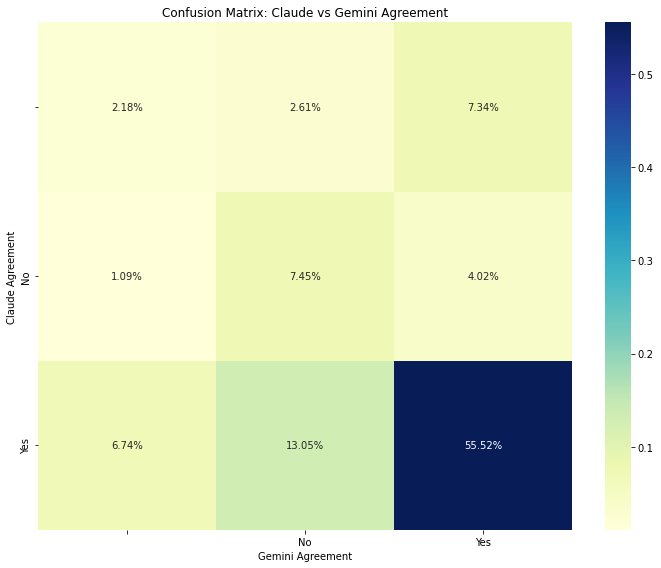

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming results_df is your DataFrame
# Create a crosstab of the agreements using counts
confusion_matrix = pd.crosstab(results_df['claude_Agreement'], 
                               results_df['gemini_Agreement'], 
                               normalize='all')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='.2%', cmap='YlGnBu', cbar=True)

plt.title('Confusion Matrix: Claude vs Gemini Agreement')
plt.xlabel('Gemini Agreement')
plt.ylabel('Claude Agreement')

# Display the plot
plt.tight_layout()


# Display the plot
#plt.tight_layout()
plt.savefig('./images/confusion_matrix.png',  dpi=300, facecolor='white')
plt.show()

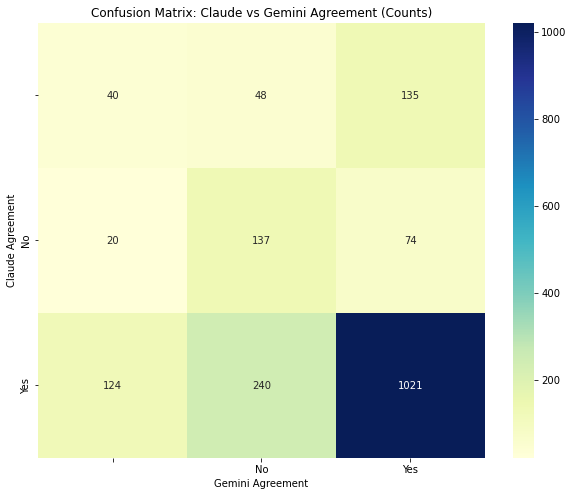

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming results_df is your DataFrame
# Create a crosstab of the agreements using counts
confusion_matrix = pd.crosstab(results_df['claude_Agreement'], 
                               results_df['gemini_Agreement'])

# Create the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=True, edgecolor='white')

plt.title('Confusion Matrix: Claude vs Gemini Agreement (Counts)')
plt.xlabel('Gemini Agreement')
plt.ylabel('Claude Agreement')



# Display the plot
#plt.tight_layout()
plt.savefig('./images/confusion_matrix_counts.png',  dpi=300, facecolor='white')
plt.show()